In [1]:
# caveat: I removed wrapping views in ACEtk to make ENDFtk and ACEtk work together
import ENDFtk
import ACEtk
import scion

import matplotlib.pyplot as plot
%matplotlib notebook

In [2]:
# the files we want to look at
endffile = '../performance/u235.endf'
acefile = '/Users/ftuser/Desktop/Lib80x/Lib80x/U/92235.800nc'

In [3]:
# open the ENDF and ACE file
tape = ENDFtk.tree.Tape.from_file( endffile )
endf = tape.materials.front().parse()
ace = ACEtk.ContinuousEnergyTable.from_file( acefile )

[info] Found unsupported section MF8 MT4 - skipping file


In [4]:
# convert to the proper Legendre coefficients
def convert( coefficients ) :
    
    converted = [ 0.5 ]
    for i in range( 1, len( coefficients ) + 1 ) :
        
        converted.append( ( 2 * i + 1 ) / 2 * coefficients[i - 1] )
    
    return converted

Some information:

ENDF/B-VIII.0 U235 uses a mixed Legendre-Tabulated angular distribution for elastic scattering. According to ENDF rules, the energy point at which the representation goes from Legendre to tabulated needs to have both a Legendre representation and a tabulated representation. Both are extracted.

In [5]:
# retrieve the ENDF data for 15 MeV (the one based on legendre polynomials and the duplicate tabulated one)
endf_elastic = endf.file( 4 ).section( 2 ).distributions

index = -17

incident_energy = endf_elastic.incident_energies[index]
endf_legendre = scion.math.LegendreSeries( convert( endf_elastic.angular_distributions[index].coefficients ) )
endf_table = scion.math.LinearLinearTable( endf_elastic.angular_distributions[index+1].cosines,
                                           endf_elastic.angular_distributions[index+1].probabilities )

print( 'order: ', endf_legendre.order )
print( 'table size: ', len( endf_table.x ) )

order:  58
table size:  91


In [6]:
# various cut-offs for the Legendre coefficient series
# the Legendre order is above 50 for these angular distributions
endf_legendre_c1 = scion.math.LegendreSeries( endf_legendre.coefficients[:22] ) # keep c_i > 1e-4

print( 'order: ', endf_legendre_c1.order )
print( 'last coefficient: ', endf_legendre_c1.coefficients[-1] )

order:  21
last coefficient:  0.0015020590149999998


In [7]:
# retrieve the ACE pdf/cdf for 15 MeV (the one based on legendre polynomials and the duplicate tabulated one)
# both are added to the ACE file - not something that is required I think
ace_elastic = ace.angular_distribution_block.angular_distribution_data(0)

index = -17

incident_energy = ace_elastic.incident_energies[index]
ace_legendre = ace_elastic.distributions[index]
ace_table = ace_elastic.distributions[index+1]

<IPython.core.display.Javascript object>


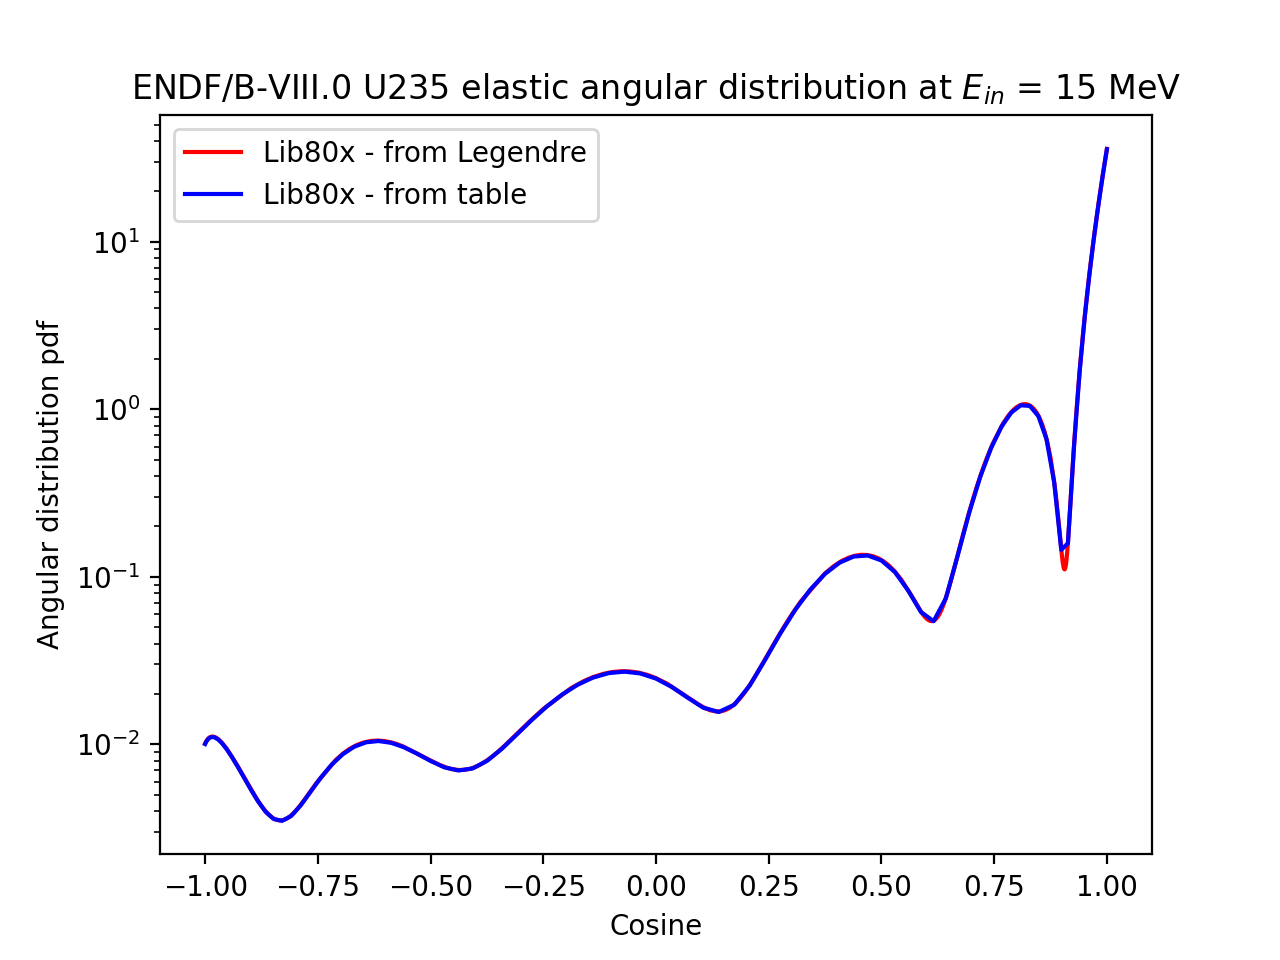

In [8]:
# plot the ace data
plot.figure()
plot.plot( ace_legendre.cosines, ace_legendre.pdf, label = 'Lib80x - from Legendre', color = 'red', linewidth = 1.5 )
plot.plot( ace_table.cosines, ace_table.pdf, label = 'Lib80x - from table', color = 'blue', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution pdf' )
plot.title( 'ENDF/B-VIII.0 U235 elastic angular distribution at $E_{in}$ = 15 MeV' )
plot.yscale( 'log' )
plot.legend()
plot.show()

<IPython.core.display.Javascript object>


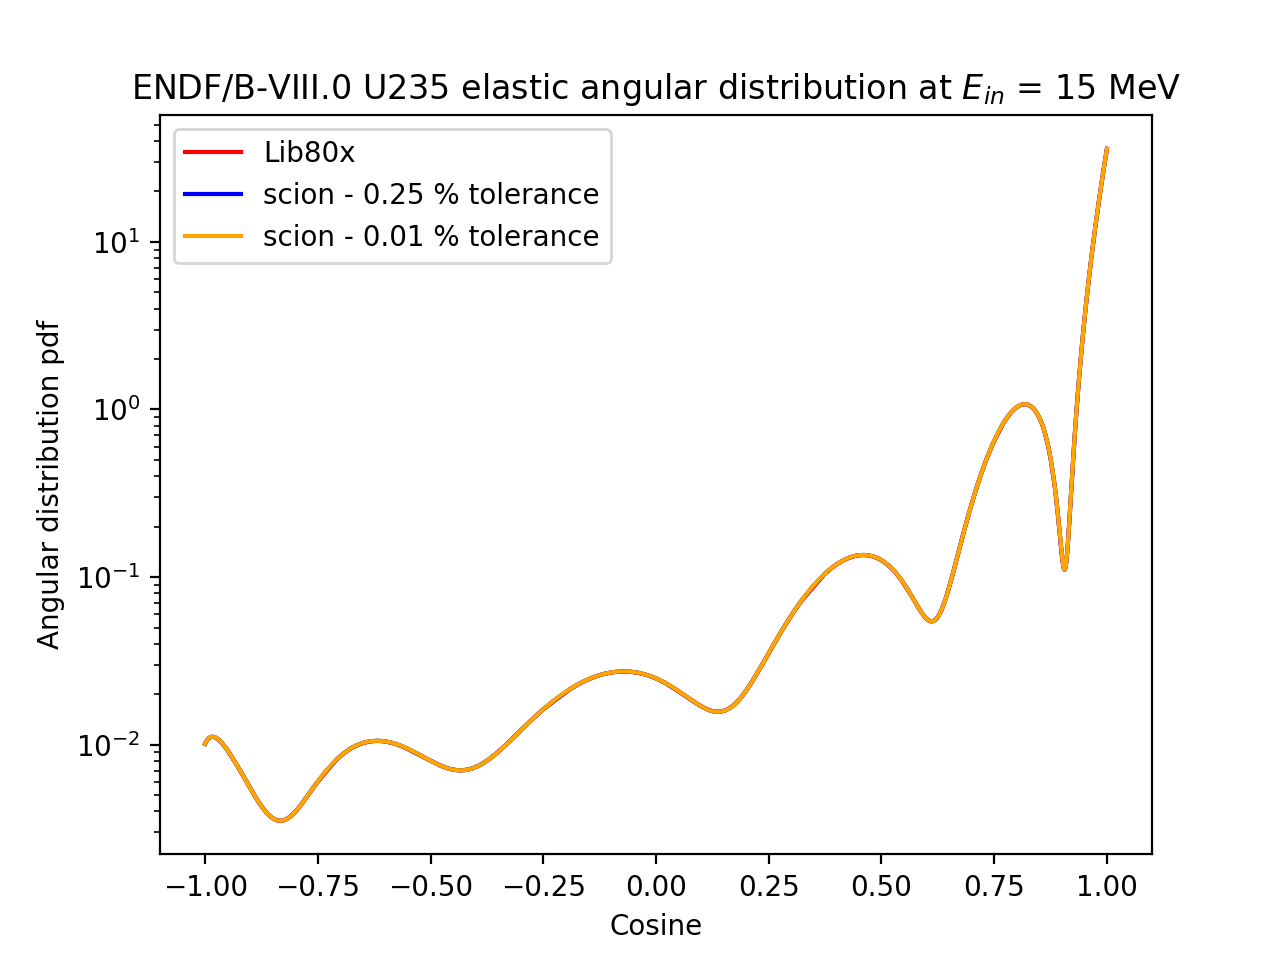

In [9]:
# linearise the pdf at different tolerances
plot1 = endf_legendre.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )
plot2 = endf_legendre.linearise( scion.linearisation.ToleranceConvergence( .0001 ) )

# plot the data
plot.figure()
plot.plot( ace_legendre.cosines, ace_legendre.pdf, label = 'Lib80x', color = 'red', linewidth = 1.5 )
plot.plot( plot1.x, plot1.y, label = 'scion - 0.25 % tolerance', color = 'blue', linewidth = 1.5 )
plot.plot( plot2.x, plot2.y, label = 'scion - 0.01 % tolerance', color = 'orange', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution pdf' )
plot.title( 'ENDF/B-VIII.0 U235 elastic angular distribution at $E_{in}$ = 15 MeV' )
plot.yscale( 'log' )
plot.legend()
plot.show()

In [10]:
print( len( ace_legendre.cosines ) )
print( len( plot1.x ) )
print( len( plot2.x ) )

226
257
1255


<IPython.core.display.Javascript object>


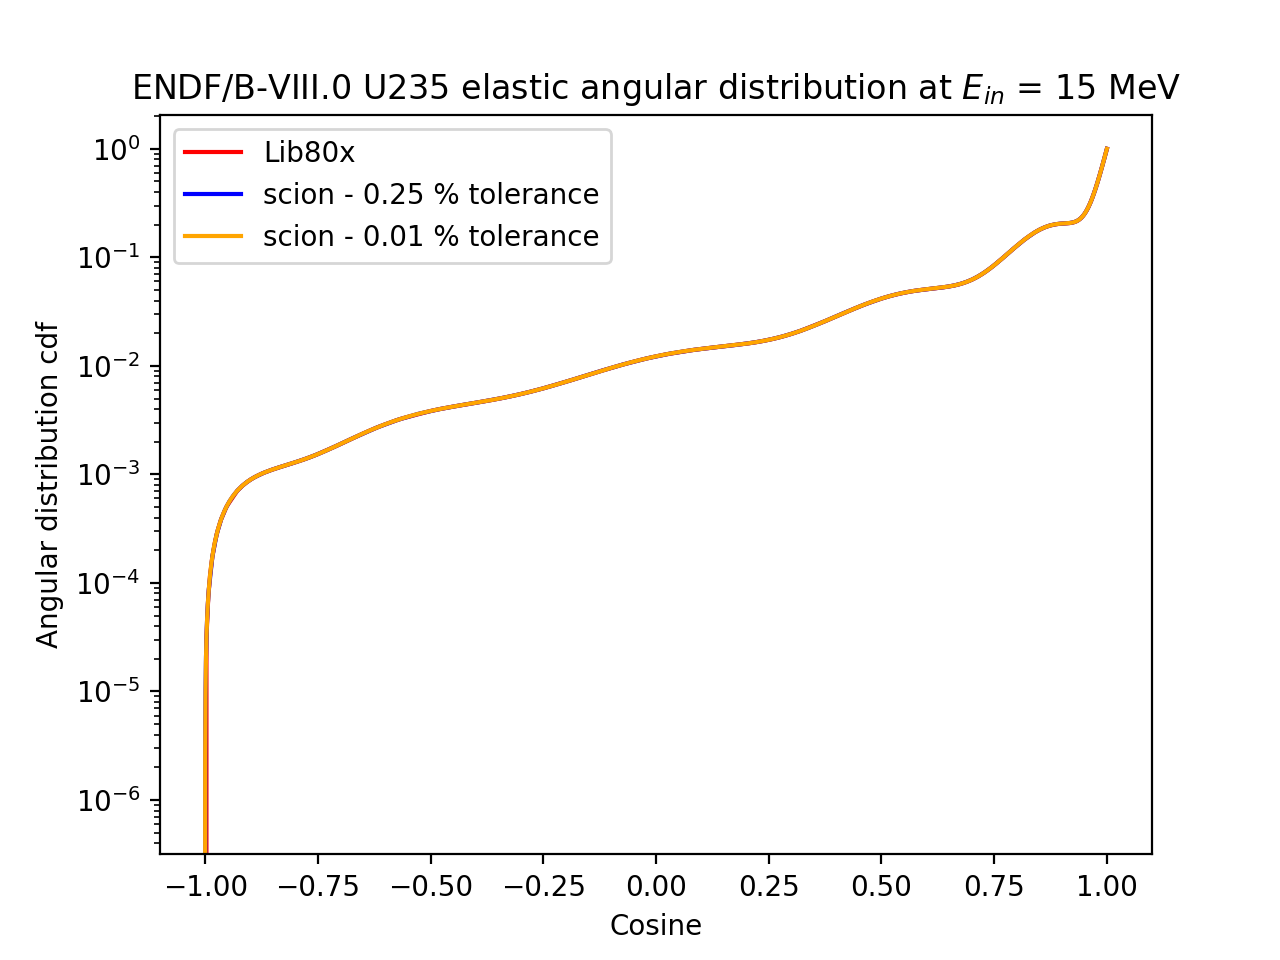

In [11]:
# we can linearise the cdf directly based on the primitive of the pdf as a Legendre series
endf_cdf = endf_legendre.primitive( -1.0 ) # the integral[-1,x] of the endf_legendre series

plot1 = endf_cdf.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )
plot2 = endf_cdf.linearise( scion.linearisation.ToleranceConvergence( .0001 ) )

# plot the data
plot.figure()
plot.plot( ace_legendre.cosines, ace_legendre.cdf, label = 'Lib80x', color = 'red', linewidth = 1.5 )
plot.plot( plot1.x, plot1.y, label = 'scion - 0.25 % tolerance', color = 'blue', linewidth = 1.5 )
plot.plot( plot2.x, plot2.y, label = 'scion - 0.01 % tolerance', color = 'orange', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution cdf' )
plot.title( 'ENDF/B-VIII.0 U235 elastic angular distribution at $E_{in}$ = 15 MeV' )
plot.yscale( 'log' )
plot.legend()
plot.show()

In [12]:
# fun fact: the cdf is a lot smoother than the pdf so we need a lot less points to represent it as the pdf
# at the same tolerances
print( len( ace_legendre.cosines ) )
print( len( plot1.x ) )
print( len( plot2.x ) )

226
115
560


<IPython.core.display.Javascript object>


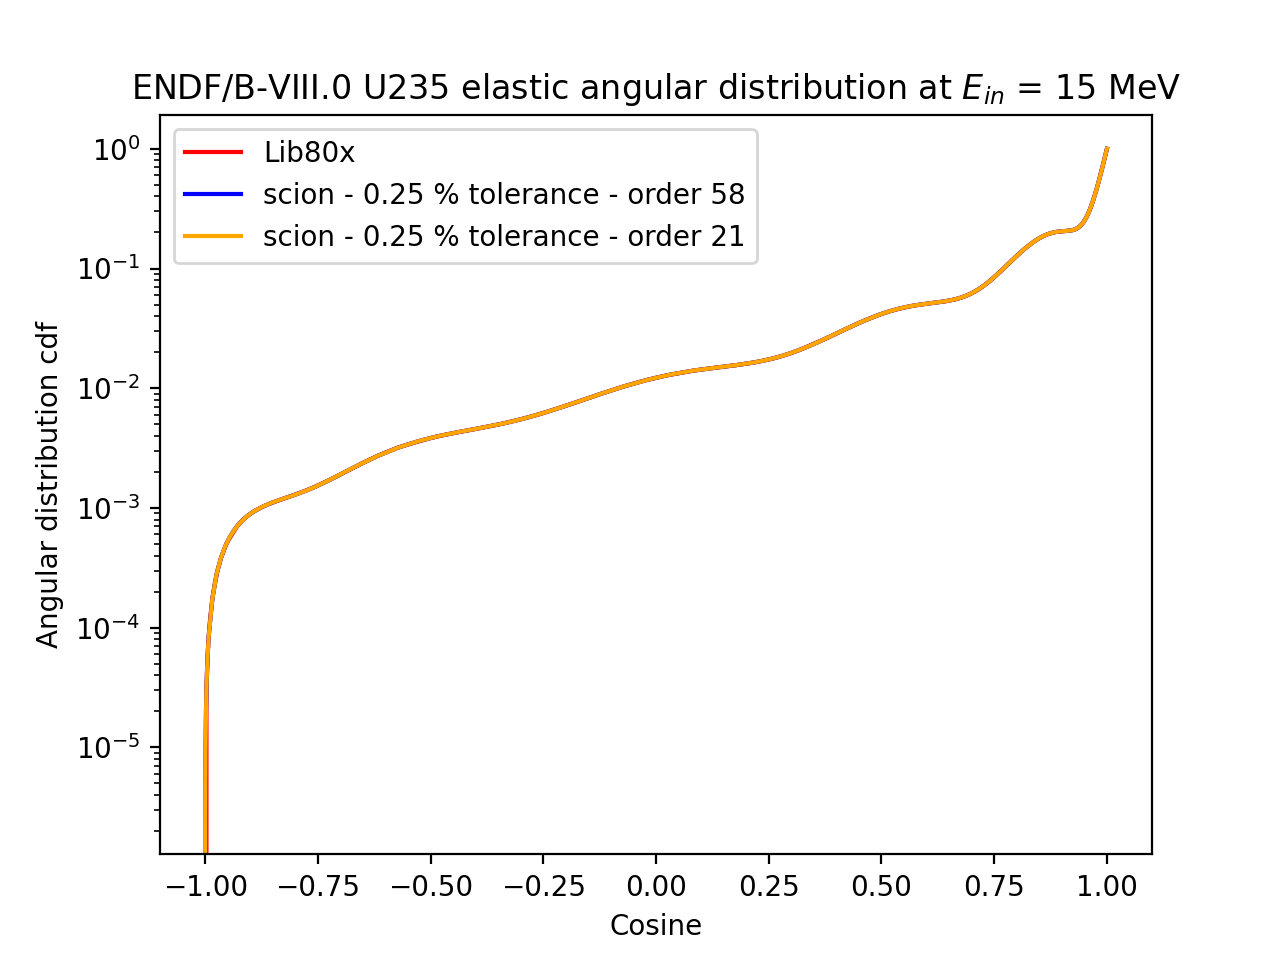

In [13]:
endf_cdf = endf_legendre.primitive( -1 )
endf_cut_cdf = endf_legendre_c1.primitive( -1 )

plot1 = endf_cdf.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )
plot2 = endf_cut_cdf.linearise( scion.linearisation.ToleranceConvergence( .0025 ) )

# plot the data
plot.figure()
plot.plot( ace_legendre.cosines, ace_legendre.cdf, label = 'Lib80x', color = 'red', linewidth = 1.5 )
plot.plot( plot1.x, plot1.y, label = 'scion - 0.25 % tolerance - order 58', color = 'blue', linewidth = 1.5 )
plot.plot( plot2.x, plot2.y, label = 'scion - 0.25 % tolerance - order 21', color = 'orange', linewidth = 1.5 )
plot.xlabel( 'Cosine' )
plot.ylabel( 'Angular distribution cdf' )
plot.title( 'ENDF/B-VIII.0 U235 elastic angular distribution at $E_{in}$ = 15 MeV' )
plot.yscale( 'log' )
plot.legend()
plot.show()

In [14]:
print( len( ace_legendre.cosines ) )
print( len( plot1.x ) )
print( len( plot2.x ) )

226
115
117


In [15]:
# we can verify that the pdf never goes below zero in [-1,1] by calculating the roots of the pdf on the real axis
print( 'roots: ', endf_legendre.roots() )
print( 'roots: ', endf_legendre_c1.roots() )

roots:  [-27490.864496728645, 27491.02615564107]
roots:  [-1.0182290789817323]


In [16]:
# we can verify that the cdf is monotonically increasing in [-1,1] by calculating the roots of the 
# first derivative of the cdf on the real axis and showing that the derivative is always above zero
# and yes: I know that boils down to calculating the roots of the pdf but I'm flexing the interface here :-)
print( 'roots: ', endf_legendre.primitive( -1 ).derivative().roots() )
print( 'roots: ', endf_legendre_c1.primitive( -1 ).derivative().roots() )

roots:  [-29041.29413192659, 29041.253301480956]
roots:  [-1.0182290789833834]
